In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
    .config("spark.driver.memory", "16g")\
    .getOrCreate()

spark

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyspark.sql.functions as F
import pyspark.sql.types as T

from collections import Iterable
from cycler import cycler
from pyspark.sql.functions import col, lit

from common import *

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_colwidth', None)

plt.rc('axes', labelsize=15, titlesize=15) 
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('legend', fontsize=15)

<ipython-input-2-1f3079a7c32c>:10: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Iterable


In [41]:
def get_index(prefix):
    client_sdf = spark.read.csv(f"{prefix}/*/client/0/metadata.csv", header=True)\
        .withColumn(
            "prefix",
            ancestor_udf(F.input_file_name(), lit(3))
        )

    server_sdf = spark.read.csv(f"{prefix}/*/server/0-0/metadata.csv", header=True)\
        .withColumn(
            "prefix",
            ancestor_udf(F.input_file_name(), lit(3))
        )

    return server_sdf.join(client_sdf, on='prefix')\
        .withColumn("duration", col("duration").cast(T.IntegerType()))\
        .withColumn("txns", col("txns").cast(T.IntegerType()))\
        .withColumn("clients", col("clients").cast(T.IntegerType()))\
        .withColumn("rate", col("rate").cast(T.IntegerType()))

# Throughput

In [42]:
THRP_PREFIX = "main/ycsb"

IGNORE_CACHE = False

thrp_index_df = from_cache_or_compute(
    f'{THRP_PREFIX}/index.parquet',
    lambda: get_index(THRP_PREFIX).toPandas().convert_dtypes().astype({
        "wl:hot": "int32",
        "wl:mh": "int32",
        "wl:mp": "int32"
    }),
    ignore_cache=IGNORE_CACHE,
)
thrp_index_df

,prefix,version,config_name,duration,txns,clients,rate,sample,wl:name,wl:mh,...,wl:hot_records,wl:mh_zipf,wl:mp_parts,wl:hot,wl:value_size,wl:mh_homes,wl:writes,wl:nearest,wl:sp_partition,wl:sh_home
0,file:/home/ctring/data/detock/main/ycsb/baseline-hot10000mp100mh100,1.0.1012,baseline.conf,60,2000000,3000,0,10,basic,100,...,2,1,2,10000,50,2,10,1,-1,-1
1,file:/home/ctring/data/detock/main/ycsb/ddr_only-hot10000mp100mh100,1.0.1012,ddr_only.conf,60,2000000,3000,0,10,basic,100,...,2,1,2,10000,50,2,10,1,-1,-1
2,file:/home/ctring/data/detock/main/ycsb/ddr_ts-hot10000mp100mh100,1.0.1012,ddr_ts.conf,60,2000000,3000,0,10,basic,100,...,2,1,2,10000,50,2,10,1,-1,-1
3,file:/home/ctring/data/detock/main/ycsb/baseline-hot10000mp100mh25,1.0.1012,baseline.conf,60,2000000,3000,0,10,basic,25,...,2,1,2,10000,50,2,10,1,-1,-1
4,file:/home/ctring/data/detock/main/ycsb/baseline-hot10000mp100mh50,1.0.1012,baseline.conf,60,2000000,3000,0,10,basic,50,...,2,1,2,10000,50,2,10,1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,file:/home/ctring/data/detock/main/ycsb/ddr_ts_no_ddr-hot100mp50mh0,1.0.1012,ddr_ts_no_ddr.conf,60,2000000,3000,0,10,basic,0,...,2,1,2,100,50,2,10,1,-1,-1
92,file:/home/ctring/data/detock/main/ycsb/baseline-hot100mp0mh0,1.0.1012,baseline.conf,60,2000000,3000,0,10,basic,0,...,2,1,2,100,50,2,10,1,-1,-1
93,file:/home/ctring/data/detock/main/ycsb/ddr_only-hot100mp0mh0,1.0.1012,ddr_only.conf,60,2000000,3000,0,10,basic,0,...,2,1,2,100,50,2,10,1,-1,-1
94,file:/home/ctring/data/detock/main/ycsb/ddr_ts-hot100mp0mh0,1.0.1012,ddr_ts.conf,60,2000000,3000,0,10,basic,0,...,2,1,2,100,50,2,10,1,-1,-1


## Compute everything or read from cache

In [39]:
IGNORE_CACHE = False

def compute_throughput(prefix):
    res = throughput(
        spark,
        prefix,
        start_offset_sec=10,
        duration_sec=50
    ).first().throughput
    print(prefix, res)
    return res


def compute_all_throughputs(index_sdf):
    # Extract all prefixes in the index
    throughput_df = index_sdf.select("prefix").toPandas()
    # Compute the throughput of each prefix
    throughput_df["throughput"] = throughput_df.apply(lambda r : compute_throughput(r["prefix"]), axis=1)
    # Associate metadata from the index to the throughputs
    return throughput_df.merge(index_sdf.toPandas(), on="prefix")


throughput_df = from_cache_or_compute(
    f'{THRP_PREFIX}/throughput.parquet',
    lambda: compute_all_throughputs(get_index(THRP_PREFIX)),
    ignore_cache=IGNORE_CACHE,
)

## Compute incrementally (only run if needed)

### Update rows

In [ ]:
tdf = throughput_df
MASK = (tdf['wl:hot'] == 10000) & (tdf['wl:mh'] == 25) & (tdf["wl:mp"] == 0)
throughput_df.loc[MASK, "throughput"] = throughput_df.loc[MASK, :].apply(lambda r : compute_throughput(r["prefix"]), axis=1)
throughput_df.to_parquet(f'{THRP_PREFIX}/throughput.parquet')
print(f"Saved to: {f'{THRP_PREFIX}/throughput.parquet'}")

file:/home/ctring/data/detock/main/ycsb/baseline-hot10000mp0mh25 87558.17339420912
file:/home/ctring/data/detock/main/ycsb/ddr_only-hot10000mp0mh25 97684.54836845583
file:/home/ctring/data/detock/main/ycsb/ddr_ts-hot10000mp0mh25 97138.08473350911
Saved to: main/ycsb/throughput.parquet


### Add new rows

In [127]:
new_rows = compute_all_throughputs(
    get_index(THRP_PREFIX).where(col("config_name") == "ddr_only_no_ddr.conf")
)

throughput_df = pd.concat([throughput_df, new_rows])

file:/home/ctring/data/slog/main/ycsb/ddr_only_no_ddr-hot10000mp0mh0 126913.74370409675
file:/home/ctring/data/slog/main/ycsb/ddr_only_no_ddr-hot10000mp100mh0 48989.9348274513
file:/home/ctring/data/slog/main/ycsb/ddr_only_no_ddr-hot10000mp50mh0 77912.7728713007
file:/home/ctring/data/slog/main/ycsb/ddr_only_no_ddr-hot100mp0mh0 112105.85403670403
file:/home/ctring/data/slog/main/ycsb/ddr_only_no_ddr-hot100mp100mh0 55390.55823149894
file:/home/ctring/data/slog/main/ycsb/ddr_only_no_ddr-hot100mp50mh0 73646.73628771887


In [ ]:
throughput_df.to_parquet(f'{THRP_PREFIX}/throughput.parquet')
print(f"Saved to: {f'{THRP_PREFIX}/throughput.parquet'}")

## Plot

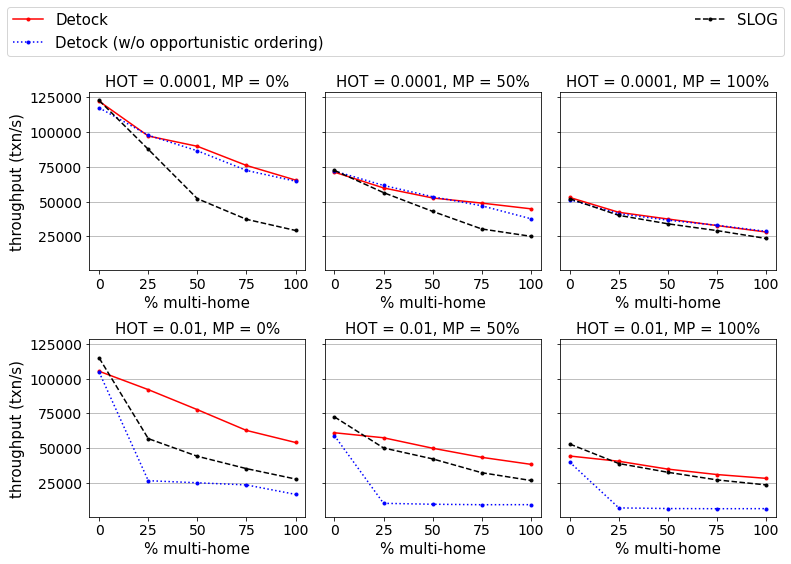

In [6]:
fig, axes = plt.subplots(2, 3, figsize=(11, 7), sharey=True)

configs = ["ddr_ts.conf", "ddr_only.conf", "baseline.conf"]
mp_pcts = sorted(throughput_df["wl:mp"].unique())
mh_pcts = sorted(throughput_df["wl:mh"].unique())
hots = sorted(throughput_df["wl:hot"].unique(), reverse=True)

ignored_configs = ['ddr_only_no_ddr.conf', 'ddr_ts_no_ddr.conf']

config_to_label = {
    'baseline.conf': 'SLOG',
    'ddr_only.conf': 'Detock (w/o opportunistic ordering)',
    'ddr_ts.conf': 'Detock'
}

pc = cycler(linestyle=['-', ':', '--']) + cycler(color='rbk')
for ax_r in axes:
    for ax in ax_r:
        ax.set_prop_cycle(pc)

for config in configs:
    if config in ignored_configs:
        continue
    for r, hot in enumerate(hots):
        for c, mp_pct in enumerate(mp_pcts):
            mask = (throughput_df["config_name"] == config) & (throughput_df["wl:mp"] == mp_pct) & (throughput_df["wl:hot"] == hot)
            label = config_to_label[config] if r == 0 and c == 0 else '_nolegend_'
            filtered = throughput_df[mask].sort_values("wl:mh")
            filtered.plot(ax=axes[r, c], x="wl:mh", y="throughput", label=label, marker='.', legend=False)
            axes[r, c].set_title(f"HOT = {1/hot}, MP = {mp_pct}%")
            axes[r, c].set_ylabel("throughput (txn/s)")
            axes[r, c].set_xlabel("% multi-home")
            axes[r, c].set_xticks(mh_pcts)
            axes[r, c].grid(axis='y')

fig.tight_layout()
fig.legend(bbox_to_anchor=(0, 1, 1, 0), loc='lower left', mode='expand', ncol=2)

fig.savefig('output/micro-throughput.pdf', bbox_inches='tight')


# Deadlocks

In [21]:
mask = (
    (thrp_index_df["wl:hot"] == 100) &
    (thrp_index_df["wl:mp"] == 50) &
    (
        (thrp_index_df["config_name"] == "ddr_ts.conf") |
        (thrp_index_df["config_name"] == "ddr_only.conf")
    )
)
deadlocks_index_df = thrp_index_df[mask]
deadlocks_index_df

,prefix,version,config_name,duration,txns,clients,rate,sample,wl:name,wl:mh,...,wl:hot_records,wl:mh_zipf,wl:mp_parts,wl:hot,wl:value_size,wl:mh_homes,wl:writes,wl:nearest,wl:sp_partition,wl:sh_home
49,file:/home/ctring/data/detock/main/ycsb/ddr_only-hot100mp50mh100,1.0.1012,ddr_only.conf,60,2000000,3000,0,10,basic,100,...,2,1,2,100,50,2,10,1,-1,-1
57,file:/home/ctring/data/detock/main/ycsb/ddr_ts-hot100mp50mh100,1.0.1022,ddr_ts.conf,60,2000000,3000,0,10,basic,100,...,2,1,2,100,50,2,10,1,-1,-1
68,file:/home/ctring/data/detock/main/ycsb/ddr_only-hot100mp50mh25,1.0.1012,ddr_only.conf,60,2000000,3000,0,10,basic,25,...,2,1,2,100,50,2,10,1,-1,-1
69,file:/home/ctring/data/detock/main/ycsb/ddr_only-hot100mp50mh50,1.0.1012,ddr_only.conf,60,2000000,3000,0,10,basic,50,...,2,1,2,100,50,2,10,1,-1,-1
70,file:/home/ctring/data/detock/main/ycsb/ddr_only-hot100mp50mh75,1.0.1012,ddr_only.conf,60,2000000,3000,0,10,basic,75,...,2,1,2,100,50,2,10,1,-1,-1
74,file:/home/ctring/data/detock/main/ycsb/ddr_ts-hot100mp50mh25,1.0.1022,ddr_ts.conf,60,2000000,3000,0,10,basic,25,...,2,1,2,100,50,2,10,1,-1,-1
75,file:/home/ctring/data/detock/main/ycsb/ddr_ts-hot100mp50mh50,1.0.1022,ddr_ts.conf,60,2000000,3000,0,10,basic,50,...,2,1,2,100,50,2,10,1,-1,-1
76,file:/home/ctring/data/detock/main/ycsb/ddr_ts-hot100mp50mh75,1.0.1022,ddr_ts.conf,60,2000000,3000,0,10,basic,75,...,2,1,2,100,50,2,10,1,-1,-1
86,file:/home/ctring/data/detock/main/ycsb/ddr_only-hot100mp50mh0,1.0.1012,ddr_only.conf,60,2000000,3000,0,10,basic,0,...,2,1,2,100,50,2,10,1,-1,-1
90,file:/home/ctring/data/detock/main/ycsb/ddr_ts-hot100mp50mh0,1.0.1012,ddr_ts.conf,60,2000000,3000,0,10,basic,0,...,2,1,2,100,50,2,10,1,-1,-1


Saved to: main/ycsb/deadlocks.pickle


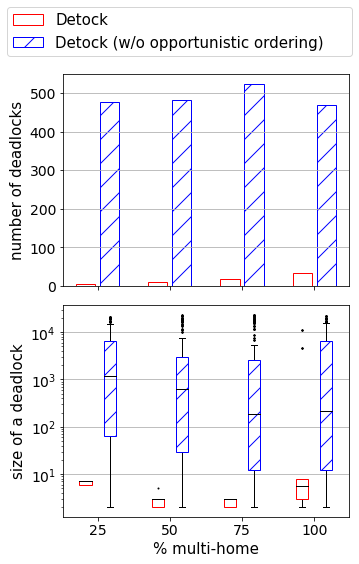

In [31]:
import pickle

mh_pcts = [25, 50, 75, 100]

configs = ["ddr_ts.conf", "ddr_only.conf"]
config_to_label = {
    'baseline.conf': 'SLOG',
    'ddr_only.conf': 'Detock (w/o opportunistic ordering)',
    'ddr_ts.conf': 'Detock'
}

# Collect data
data = []
for config in configs:
    deadlocks = []
    num_txns = []
    for mh in mh_pcts:
        mask = (deadlocks_index_df["config_name"] == config) & (deadlocks_index_df["wl:mh"] == mh)
        prefix = deadlocks_index_df.loc[mask, "prefix"].iloc[0]
        
        deadlocks_df = deadlocks_csv(spark, prefix).where(col("replica") == 0).toPandas()

        deadlocks.append(deadlocks_df["vertices"])
        num_txns.append(committed(spark, prefix))

    data.append((deadlocks, num_txns))

with open(f'{THRP_PREFIX}/deadlocks.pickle', 'wb') as f:
    pickle.dump(data, f)
    print(f'Saved to: {THRP_PREFIX}/deadlocks.pickle')

# Plot
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(5, 7))
colors='rb'
hatches = ['', '/']
for i, c in enumerate(configs):
    deadlocks, num_txns = data[i]
    # data_cnt = list(map(lambda d : d[0].count() / d[1], zip(deadlocks, num_txns)))
    data_cnt = list(map(lambda d : d[0].count(), zip(deadlocks, num_txns)))
    pos = [j * (len(configs) + 1) + i for j in range(len(data_cnt))]

    l = axes[0].bar(pos, data_cnt, label=config_to_label[c], hatch=hatches[i], fill=False, edgecolor=colors[i])
    color = l.get_children()[-1].get_facecolor()

    box = axes[1].boxplot(
        deadlocks,
        # vert=False,
        flierprops={ 'markersize': 1 },
        medianprops={ 'color': 'black' },
        positions=pos,
        manage_ticks=False,
        patch_artist=True,
    )
    for b in box['boxes']:
        b.set_fill(False)
        b.set_hatch(hatches[i])
        b.set_edgecolor(colors[i])
    
ticks = []
ticklabels = []
for i, mh in enumerate(mh_pcts):
    start = i * (len(configs) + 1)
    end = start + len(configs)
    ticks.append((start + end - 1) / 2)
    ticklabels.append(f'{mh}')
    
axes[0].set_ylabel('number of deadlocks')
axes[0].set_xticks(ticks)
axes[0].set_xticklabels(ticklabels)
# axes[0].set_yscale("log")
axes[0].grid(axis='y')

axes[1].set_xlabel("% multi-home")
axes[1].set_ylabel('size of a deadlock')
# axes[1].tick_params(axis='x', width=0, labelleft=True)
axes[1].set_yscale("log")
axes[1].grid(axis='y')

fig.legend(bbox_to_anchor=(0, 1, 1, 0), loc='lower left', mode='expand', ncol=1)
fig.tight_layout()
fig.savefig('output/micro-deadlocks.pdf', bbox_inches='tight')

# Latency

In [38]:
LAT_PREFIX = "main/ycsb-latency"

IGNORE_CACHE = False

lat_index_df = from_cache_or_compute(
    f'{LAT_PREFIX}/index.parquet',
    lambda: get_index(LAT_PREFIX).toPandas().convert_dtypes().astype({
        "wl:hot": "int32",
        "wl:mh": "int32",
        "wl:mp": "int32"
    }),
    ignore_cache=IGNORE_CACHE
)

lat_index_df

,prefix,version,config_name,duration,txns,clients,rate,sample,wl:name,wl:mh,...,wl:hot_records,wl:mh_zipf,wl:mp_parts,wl:hot,wl:value_size,wl:mh_homes,wl:writes,wl:nearest,wl:sp_partition,wl:sh_home
0,file:/home/ctring/data/detock/main/ycsb-latency/baseline-hot10000mp100mh100,1.0.1012,baseline.conf,40,2000000,200,0,10,basic,100,...,2,1,2,10000,50,2,10,1,-1,-1
1,file:/home/ctring/data/detock/main/ycsb-latency/ddr_ts-hot10000mp100mh100,1.0.1012,ddr_ts.conf,40,2000000,200,0,10,basic,100,...,2,1,2,10000,50,2,10,1,-1,-1
2,file:/home/ctring/data/detock/main/ycsb-latency/baseline-hot10000mp100mh25,1.0.1012,baseline.conf,40,2000000,200,0,10,basic,25,...,2,1,2,10000,50,2,10,1,-1,-1
3,file:/home/ctring/data/detock/main/ycsb-latency/baseline-hot10000mp100mh50,1.0.1012,baseline.conf,40,2000000,200,0,10,basic,50,...,2,1,2,10000,50,2,10,1,-1,-1
4,file:/home/ctring/data/detock/main/ycsb-latency/baseline-hot10000mp100mh75,1.0.1012,baseline.conf,40,2000000,200,0,10,basic,75,...,2,1,2,10000,50,2,10,1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55,file:/home/ctring/data/detock/main/ycsb-latency/ddr_ts-hot100mp100mh0,1.0.1012,ddr_ts.conf,20,2000000,20,0,10,basic,0,...,2,1,2,100,50,2,10,1,-1,-1
56,file:/home/ctring/data/detock/main/ycsb-latency/baseline-hot100mp50mh0,1.0.1012,baseline.conf,20,2000000,20,0,10,basic,0,...,2,1,2,100,50,2,10,1,-1,-1
57,file:/home/ctring/data/detock/main/ycsb-latency/ddr_ts-hot100mp50mh0,1.0.1012,ddr_ts.conf,20,2000000,20,0,10,basic,0,...,2,1,2,100,50,2,10,1,-1,-1
58,file:/home/ctring/data/detock/main/ycsb-latency/baseline-hot100mp0mh0,1.0.1012,baseline.conf,20,2000000,20,0,10,basic,0,...,2,1,2,100,50,2,10,1,-1,-1


In [37]:
prefixes = list(map(lambda r : r["prefix"], get_index(LAT_PREFIX).select("prefix").collect()))
latency_sdf = latency(spark, prefixes).cache()

percentile_cols = [
    F.percentile_approx("latency", 0.5).alias("percentile_50"),
    F.percentile_approx("latency", 0.90).alias("percentile_90"),
    F.percentile_approx("latency", 0.95).alias("percentile_95"),
    F.percentile_approx("latency", 0.99).alias("percentile_99"),
]

latency_pct_sh_sdf = latency_sdf\
    .where(F.size("replicas") == 1)\
    .groupBy("prefix")\
    .agg(*percentile_cols)\
    .cache()

latency_pct_mh_sdf = latency_sdf\
    .where(F.size("replicas") > 1)\
    .groupBy("prefix")\
    .agg(*percentile_cols)\
    .cache()

latency_pct_sdf = latency_sdf\
    .where(col("latency") < 400)\
    .groupBy("prefix")\
    .agg(*percentile_cols)\
    .cache()

In [40]:
IGNORE_CACHE = False

latency_pct_sh_df = from_cache_or_compute(
    f'{LAT_PREFIX}/latency_sh.parquet',
    lambda: latency_pct_sh_sdf.toPandas().merge(lat_index_df, on="prefix"),
    ignore_cache=IGNORE_CACHE,
)

latency_pct_mh_df = from_cache_or_compute(
    f'{LAT_PREFIX}/latency_mh.parquet',
    lambda: latency_pct_mh_sdf.toPandas().merge(lat_index_df, on="prefix"),
    ignore_cache=IGNORE_CACHE,
)

latency_pct_df = from_cache_or_compute(
    f'{LAT_PREFIX}/latency.parquet',
    lambda: latency_pct_sdf.toPandas().merge(lat_index_df, on="prefix"),
    ignore_cache=IGNORE_CACHE,
)


In [12]:
def plot_latency(
    df,
    mp_pcts=[0, 50, 100],
    mh_pcts=[0, 25, 50, 75, 100],
    hots=[10000, 100],
    scale='log',
    figsize=(11, 7),
    legend=True,
):
    fig, axes = plt.subplots(len(hots), len(mp_pcts), figsize=figsize, sharey=True)
    axes = np.array(axes).reshape((len(hots), len(mp_pcts)))
    configs = ["ddr_ts.conf", "baseline.conf"]

    config_to_label = {
        'ddr_ts.conf': 'Detock',
        'baseline.conf': 'SLOG',
        'ddr_only.conf': 'Detock (w/o O.O.)',
    }

    pc = (cycler(color='rk') + cycler(marker=['.', 'x'])) * cycler(linestyle=['-', '--', ':'])
    for ax_r in axes:
        for ax in ax_r:
            ax.set_prop_cycle(pc)

    for i, config in enumerate(configs):
        for r, hot in enumerate(hots):   
            for c, mp_pct in enumerate(mp_pcts):
                mask = (df["config_name"] == config) & (df["wl:mp"] == mp_pct) & (df["wl:hot"] == hot)
                filtered = df[mask].sort_values("wl:mh")
                label = config_to_label[config] + ' {}' if r == 0 and c == 0 else '_nolegend_'

                filtered.plot(ax=axes[r, c], x="wl:mh", y="percentile_50", label=label.format('p50'), legend=False)
                filtered.plot(ax=axes[r, c], x="wl:mh", y="percentile_95", label=label.format('p95'), legend=False)
                filtered.plot(ax=axes[r, c], x="wl:mh", y="percentile_99", label=label.format('p99'), legend=False)

                axes[r, c].set_title(f"HOT = {1/hot}, MP = {mp_pct}%")
                axes[r, c].set_ylabel("latency (ms)")
                axes[r, c].set_xlabel("% multi-home")
                axes[r, c].set_xticks(mh_pcts)
                axes[r, c].grid(axis='y')
                axes[r, c].set_yscale(scale)

    if legend:
        fig.legend(bbox_to_anchor=(0, 1, 1, 0), loc='lower left', mode='expand', ncol=3)

    return fig, axes


## Single-home

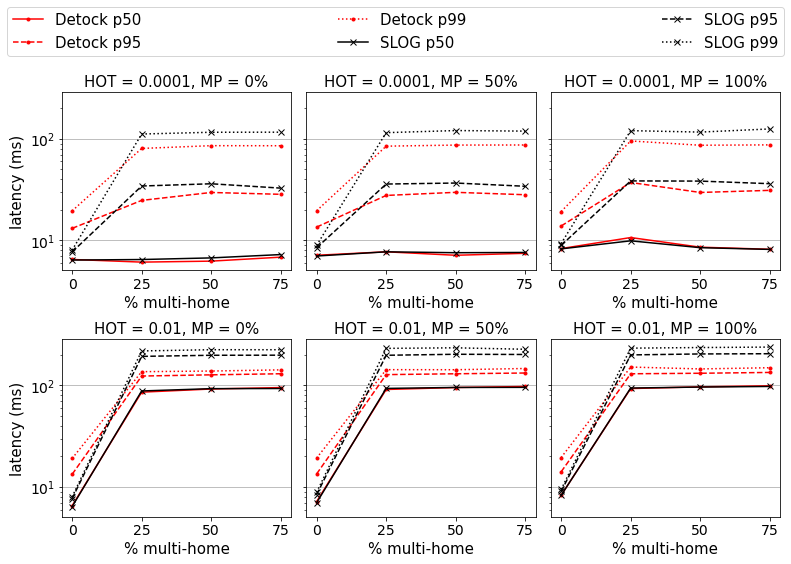

In [13]:
fig, _ = plot_latency(latency_pct_sh_df, mh_pcts=[0, 25, 50, 75])
fig.tight_layout()

In [14]:
tmp = latency(spark, [
    "file:/home/ctring/data/detock/main/ycsb-latency/baseline-hot100mp100mh50",
    "file:/home/ctring/data/detock/main/ycsb-latency/ddr_ts-hot100mp100mh50"
])\
.where(F.size("replicas") == 1)\
.toPandas().merge(lat_index_df, on="prefix")

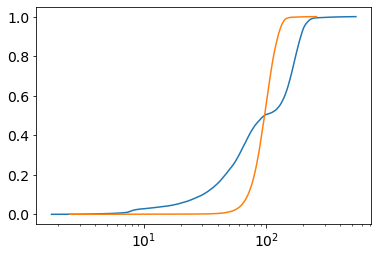

In [15]:
_, ax = plt.subplots(1, 1)
plot_cdf(tmp.loc[tmp["config_name"] == "baseline.conf", "latency"], ax=ax)
plot_cdf(tmp.loc[tmp["config_name"] == "ddr_ts.conf", "latency"], ax=ax)

## Multi-home

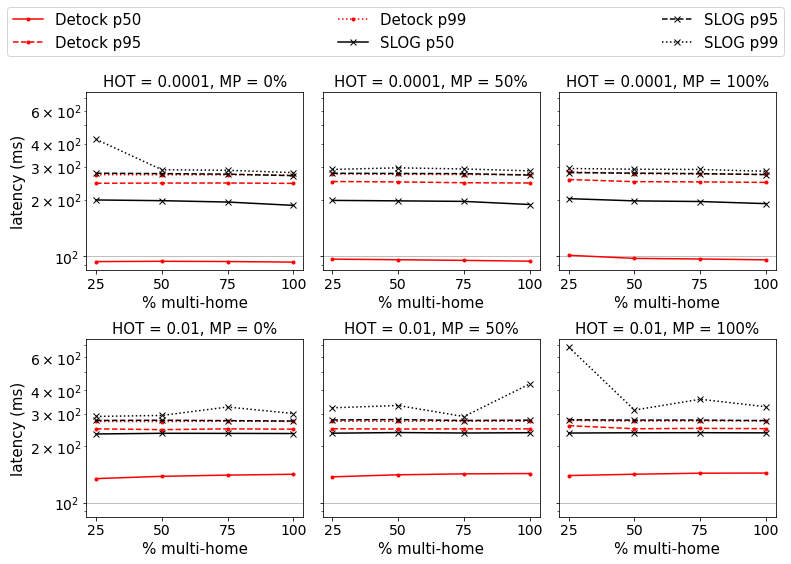

In [16]:
fig, _ = plot_latency(latency_pct_mh_df, mh_pcts=[25, 50, 75, 100])
fig.tight_layout()

In [17]:
tmp = latency(spark, [
    "file:/home/ctring/data/detock/main/ycsb-latency/baseline-hot10000mp100mh50",
    "file:/home/ctring/data/detock/main/ycsb-latency/ddr_ts-hot10000mp100mh50"
])\
.where(F.size("replicas") > 1)\
.toPandas().merge(lat_index_df, on="prefix")

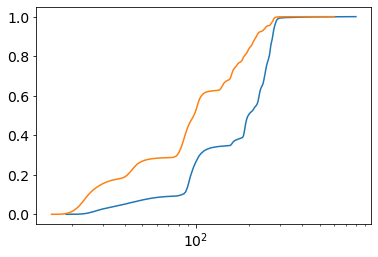

In [18]:
_, ax = plt.subplots(1, 1)
plot_cdf(tmp.loc[tmp["config_name"] == "baseline.conf", "latency"], ax=ax)
plot_cdf(tmp.loc[tmp["config_name"] == "ddr_ts.conf", "latency"], ax=ax)

## All

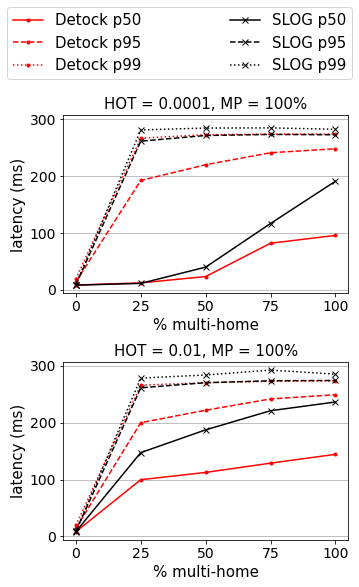

In [19]:
fig, _ = plot_latency(latency_pct_df, mp_pcts=[100], scale='linear', figsize=(5, 7), legend=False)
fig.legend(bbox_to_anchor=(0, 1, 1, 0), mode='expand', ncol=2, loc='lower left')
fig.tight_layout()
fig.savefig('output/micro-latency.pdf', bbox_inches='tight')


In [20]:
latency_pct_df.loc[
    latency_pct_df['wl:mp'] == 100, 
    [
        "config_name",
        "percentile_50",
        "percentile_95",
        "percentile_99",
        "wl:mh",
        "wl:mp",
        "wl:hot",
    ]
].sort_values(["wl:hot", "wl:mh", "config_name"])

,config_name,percentile_50,percentile_95,percentile_99,wl:mh,wl:mp,wl:hot
50,baseline.conf,8.272896,9.036288,9.454080,0,100,100
59,ddr_ts.conf,8.298752,14.106112,19.502080,0,100,100
13,baseline.conf,147.296768,261.238016,278.282496,25,100,100
40,ddr_ts.conf,99.635456,199.914752,265.839616,25,100,100
25,baseline.conf,187.306496,270.226176,283.753728,50,100,100
49,ddr_ts.conf,112.456448,221.768192,270.235392,50,100,100
37,baseline.conf,220.950528,273.590016,292.376832,75,100,100
48,ddr_ts.conf,128.772608,241.609728,272.629760,75,100,100
47,baseline.conf,236.257792,274.082560,285.226240,100,100,100
16,ddr_ts.conf,144.280320,249.038848,273.608448,100,100,100
